In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

import lagrangian_optim as lgopt
from scipy import optimize as sp_optimize

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{b}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$. 

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

p = 200
k = 4
sparsity = 0.4
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 4.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components:")
print (sk)

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)

Standard deviation of prior mixture components:
[0.         0.41421356 1.         1.82842712]
2022-03-09 16:45:54,519 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.


In [4]:
bconst = bpostmean.copy()

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj)
theta_newraph = Minv.x
b_newraph = lgopt.shrink_theta(theta_newraph, strue, wpost, sk, dj)

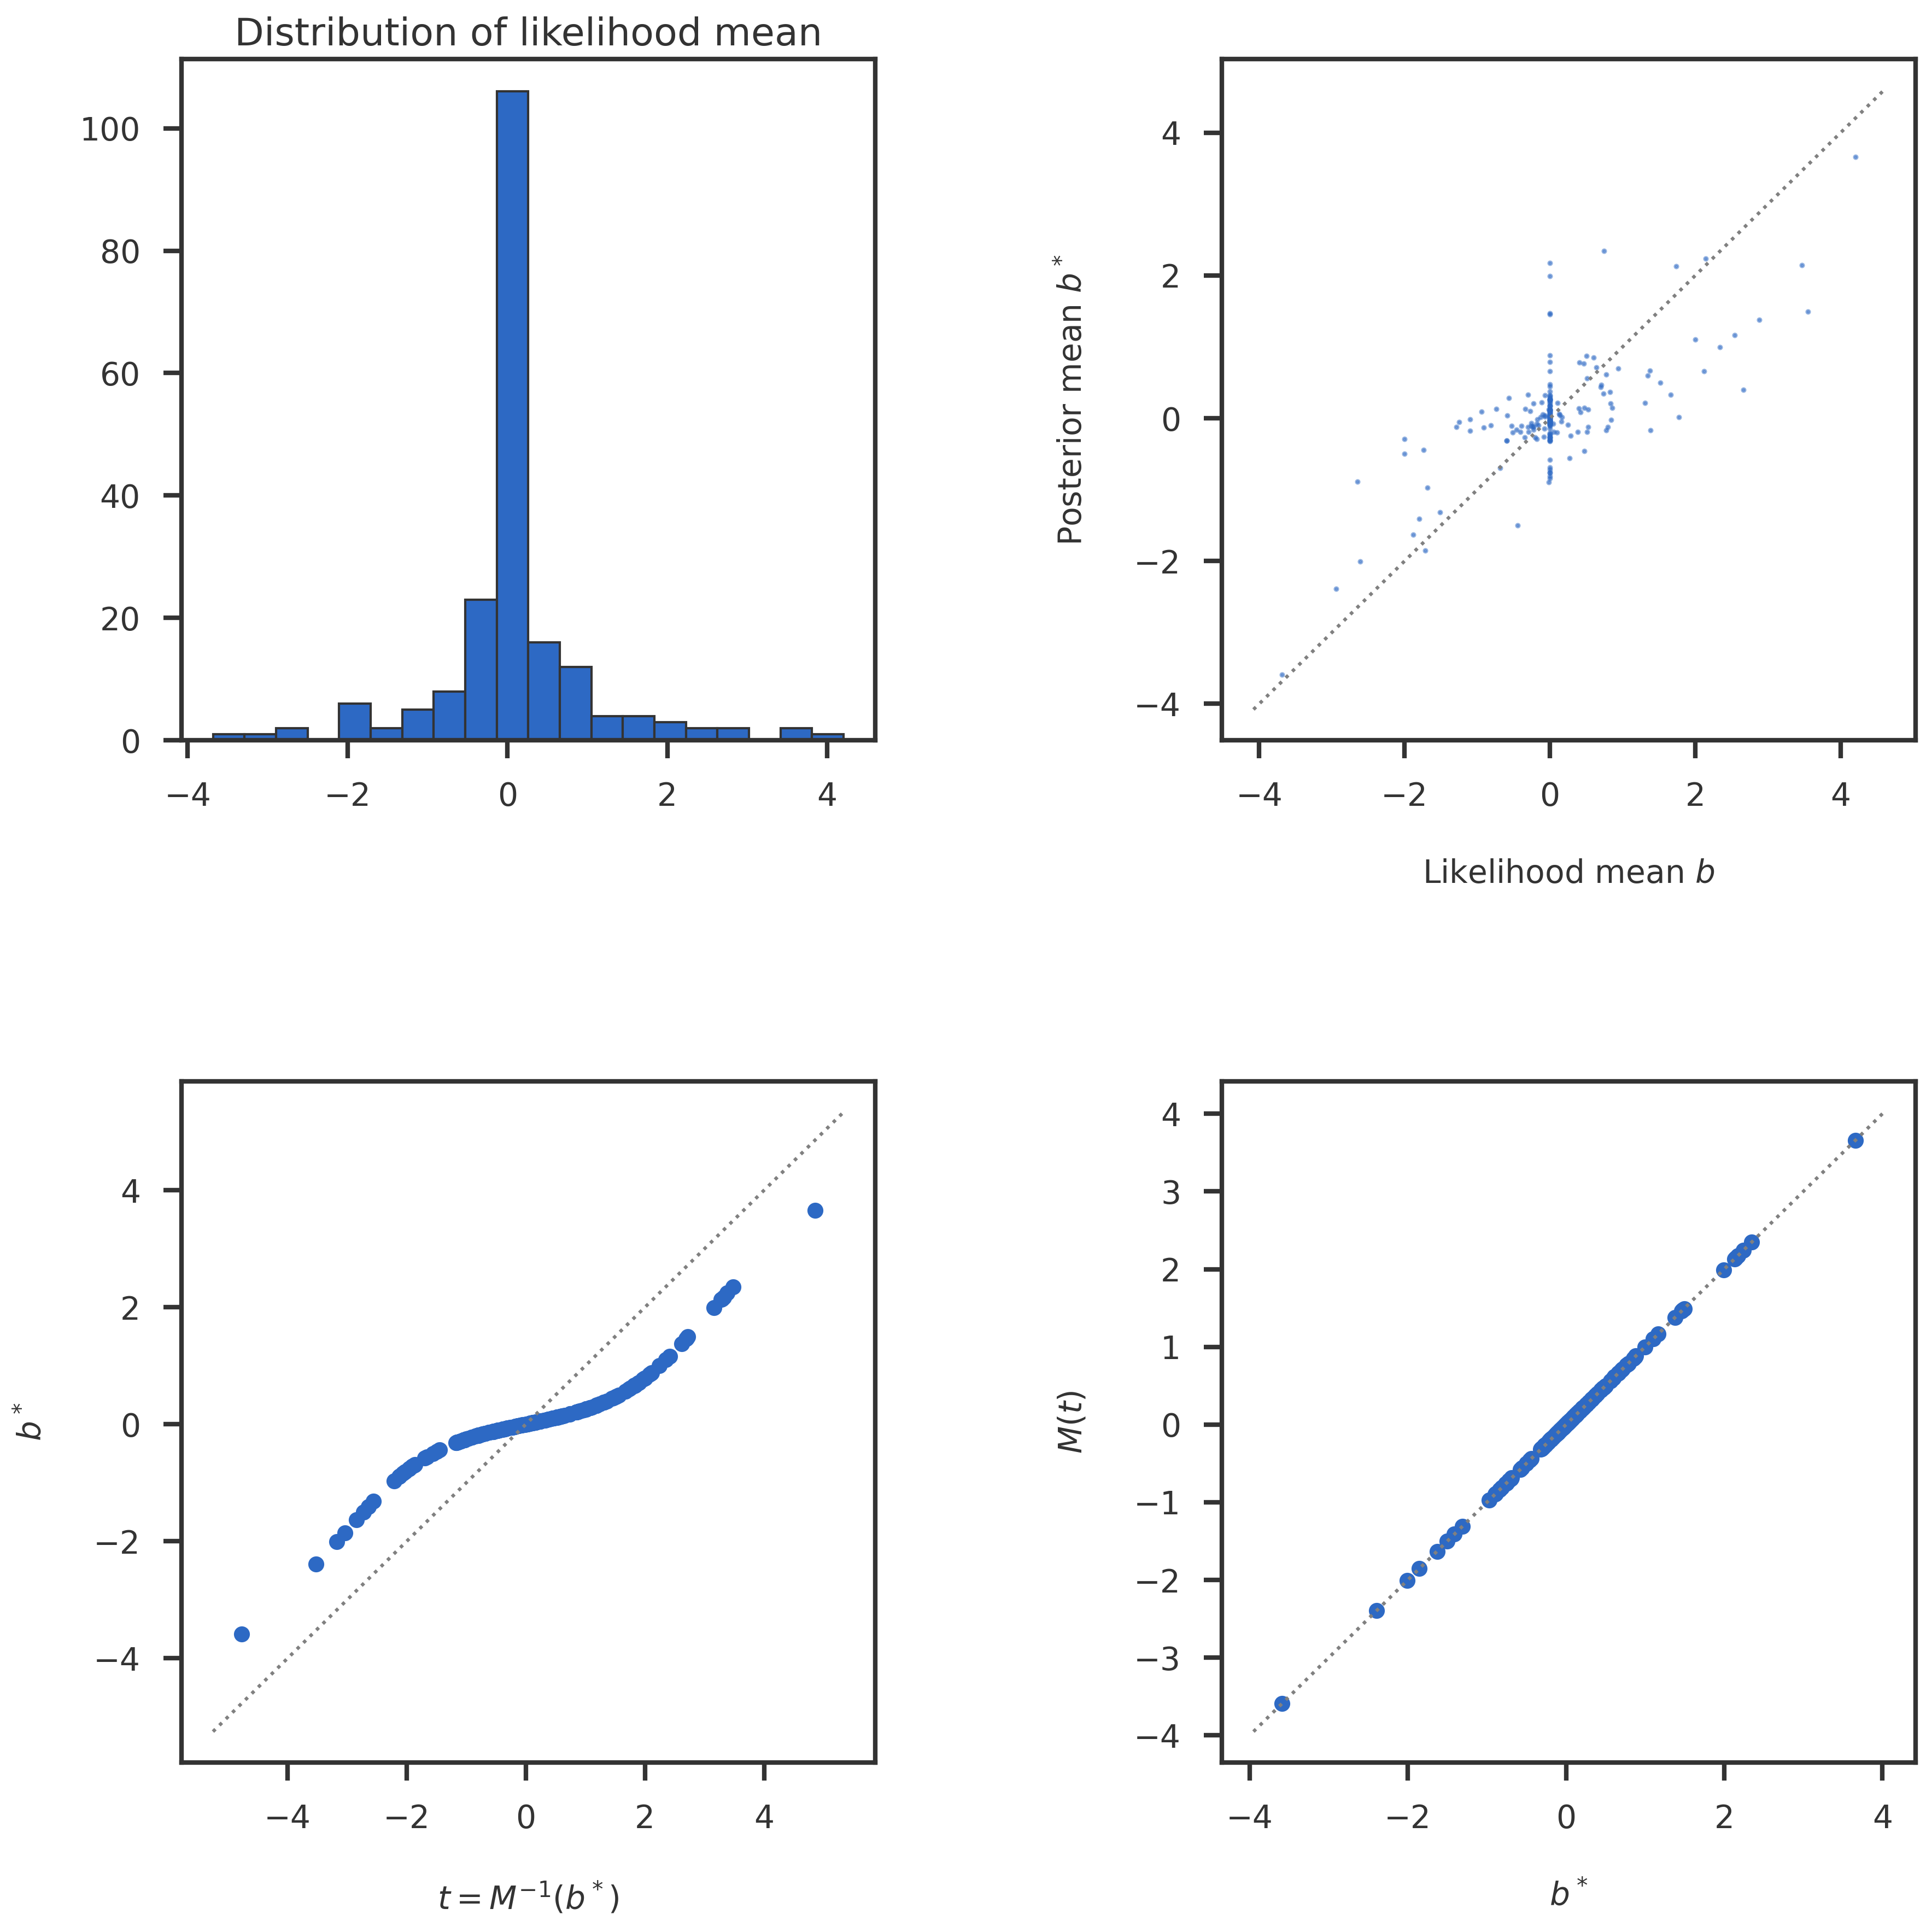

In [5]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.hist(btrue)
ax1.set_title("Distribution of likelihood mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Likelihood mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

#ax3.scatter(bconst, theta_newraph)
ax3.scatter(theta_newraph, bconst)
mpl_utils.plot_diag(ax3)
ax3.set_ylabel(r"$b^*$")
ax3.set_xlabel(r"$t = M^{-1}(b^*)$")

ax4.scatter(bconst, b_newraph)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel(r"$b^*$")
#ax4.set_ylabel(r"$M(M^{-1}(b^*))$")
ax4.set_ylabel(r"$M(t)$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

#### Prior mixture coefficients

In [6]:
wtrue

array([0.4, 0.2, 0.2, 0.2])

#### Posterior mixture coefficients

In [7]:
wpost

array([0.39216025, 0.1966412 , 0.2013797 , 0.20981884])

### Are the derivatives of the Lagrangian function zero at optimum?

In [8]:
lgrng = np.ones(p)
dLdl, dLdw, dLdt = lgopt.penalty_operator_lagrangian_deriv(theta_newraph, wpost, strue, sk, dj, lgrng, bconst)

In [12]:
M, M_bgrad, M_wgrad, M_s2grad = lgopt.shrinkage_operator(theta_newraph, strue, wpost, sk, dj)

In [17]:
nmash = NormalMeansASHScaled(theta_newraph, strue, wpost, sk, d = dj)
rho_bgrad = - nmash.logML_deriv  - nmash.yvar * nmash.logML_deriv * nmash.logML_deriv2

In [18]:
rho_bgrad

array([ 0.54457775,  0.00413189,  0.34799176,  1.22093154, -0.08738081,
        0.26258459,  0.19494982, -1.05976702,  0.15904253, -0.09392757,
        0.80990199,  0.08464455,  1.36295082,  0.950305  ,  0.15548647,
       -1.21393153,  1.36814848, -0.02942646, -1.05185482, -0.04519163,
       -0.17243118,  1.29187594, -1.02588731,  0.15869006, -0.33791409,
        0.0293364 , -0.1971862 ,  0.01940761, -0.26057815, -0.83049309,
        0.05255728, -1.12605331, -0.00864154,  1.32802567,  1.27934279,
        0.94246219, -0.04030549,  0.79885075, -0.10710797,  0.40761923,
       -0.10423264,  0.10560048, -0.01410184,  0.06726696,  0.41463329,
        0.2928593 , -0.18068516,  0.02040198,  0.55847902, -0.09230376,
        0.74008808, -0.29457517,  0.01458865, -0.17569818,  0.04011983,
        0.33645645, -0.08396606, -0.30610937,  0.04191498,  0.04313098,
       -0.02183143, -0.1773899 , -0.32589806, -0.21670492,  0.71513317,
       -0.10521196,  0.01058157,  0.02630839,  1.04611489,  1.36

In [14]:
dLdt - M_bgrad

array([ 0.54457775,  0.00413189,  0.34799176,  1.22093154, -0.08738081,
        0.26258459,  0.19494982, -1.05976702,  0.15904253, -0.09392757,
        0.80990199,  0.08464455,  1.36295082,  0.950305  ,  0.15548647,
       -1.21393153,  1.36814848, -0.02942646, -1.05185482, -0.04519163,
       -0.17243118,  1.29187594, -1.02588731,  0.15869006, -0.33791409,
        0.0293364 , -0.1971862 ,  0.01940761, -0.26057815, -0.83049309,
        0.05255728, -1.12605331, -0.00864154,  1.32802567,  1.27934279,
        0.94246219, -0.04030549,  0.79885075, -0.10710797,  0.40761923,
       -0.10423264,  0.10560048, -0.01410184,  0.06726696,  0.41463329,
        0.2928593 , -0.18068516,  0.02040198,  0.55847902, -0.09230376,
        0.74008808, -0.29457517,  0.01458865, -0.17569818,  0.04011983,
        0.33645645, -0.08396606, -0.30610937,  0.04191498,  0.04313098,
       -0.02183143, -0.1773899 , -0.32589806, -0.21670492,  0.71513317,
       -0.10521196,  0.01058157,  0.02630839,  1.04611489,  1.36

### Minimization of penalty function

Here, we minimize the penalty function $\rho(M(\theta))$ with the constraint $M(\theta) = \hat{\mathbf{b}}$, given $\sigma_k$ and $\sigma^2 = 1$. We expect to obtain $\hat{q}$ from the minimization. 

In [11]:
thetainit = theta_newraph.copy()
softmax_base = np.exp(1)
winit     = wpost.copy()
#winit, _ = initialize_ash_prior(k, sparsity = 0.98)
akinit    = np.log(winit) / np.log(softmax_base)
winit     = lgopt.softmax(akinit, base = softmax_base)
lgrng     = np.ones(p) * 1.0

initparams = np.concatenate([thetainit, lgrng, akinit])
cg_min = sp_optimize.minimize(lgopt.objective_numeric_lagrangian, 
                              initparams,
                              args = (strue, sk, dj, bpostmean, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 100, 'return_all': True}
                             )

         Current function value: 0.000135
         Iterations: 100
         Function evaluations: 79380
         Gradient evaluations: 196


Est. w:  0.000, 0.000, 1.000, 0.000
Est. Lagrangian (for non-zero b): 
[-0.46952472 -0.32725205 -1.100732   -0.20684919  0.89701391  0.11147147
 -0.66925944  2.39202927 -1.49353638  0.88865616  0.1872283  -2.12902121
  3.58900941  0.26062077 -0.0651703   0.97182908 -0.78224771  0.05049222
  0.12518444 -0.37093326  0.1222327  -0.1236396   0.01791719 -0.28572263
  0.19450553  0.10974905 -0.61427223  0.28703817  0.19012114 -0.05391366
  0.19161264  0.3107769  -0.59516132  0.12324048 -0.01345679 -0.70083427
 -2.23984143 -0.14362884  0.1613328   0.55931343  0.14270691 -0.08592562
  0.17706191 -1.37788752 -0.85097087  0.12886436  0.08793983  0.0750721
 -0.2137398  -0.21711859  0.17093333  0.44061692  0.24225035 -0.13089605
 -0.12144237  0.69810552 -0.15001221  2.00538812 -2.3464426   1.3135645
  0.17051152 -0.02113673 -0.5618795  -0.32793607 -0.10076961 -2.14620955
 -0.01590013 -0.04810601 -0.01269197 -0.0407007   0.10711503  0.26684
 -0.13855892  1.41120808  0.49862451  1.50123319  0.309891

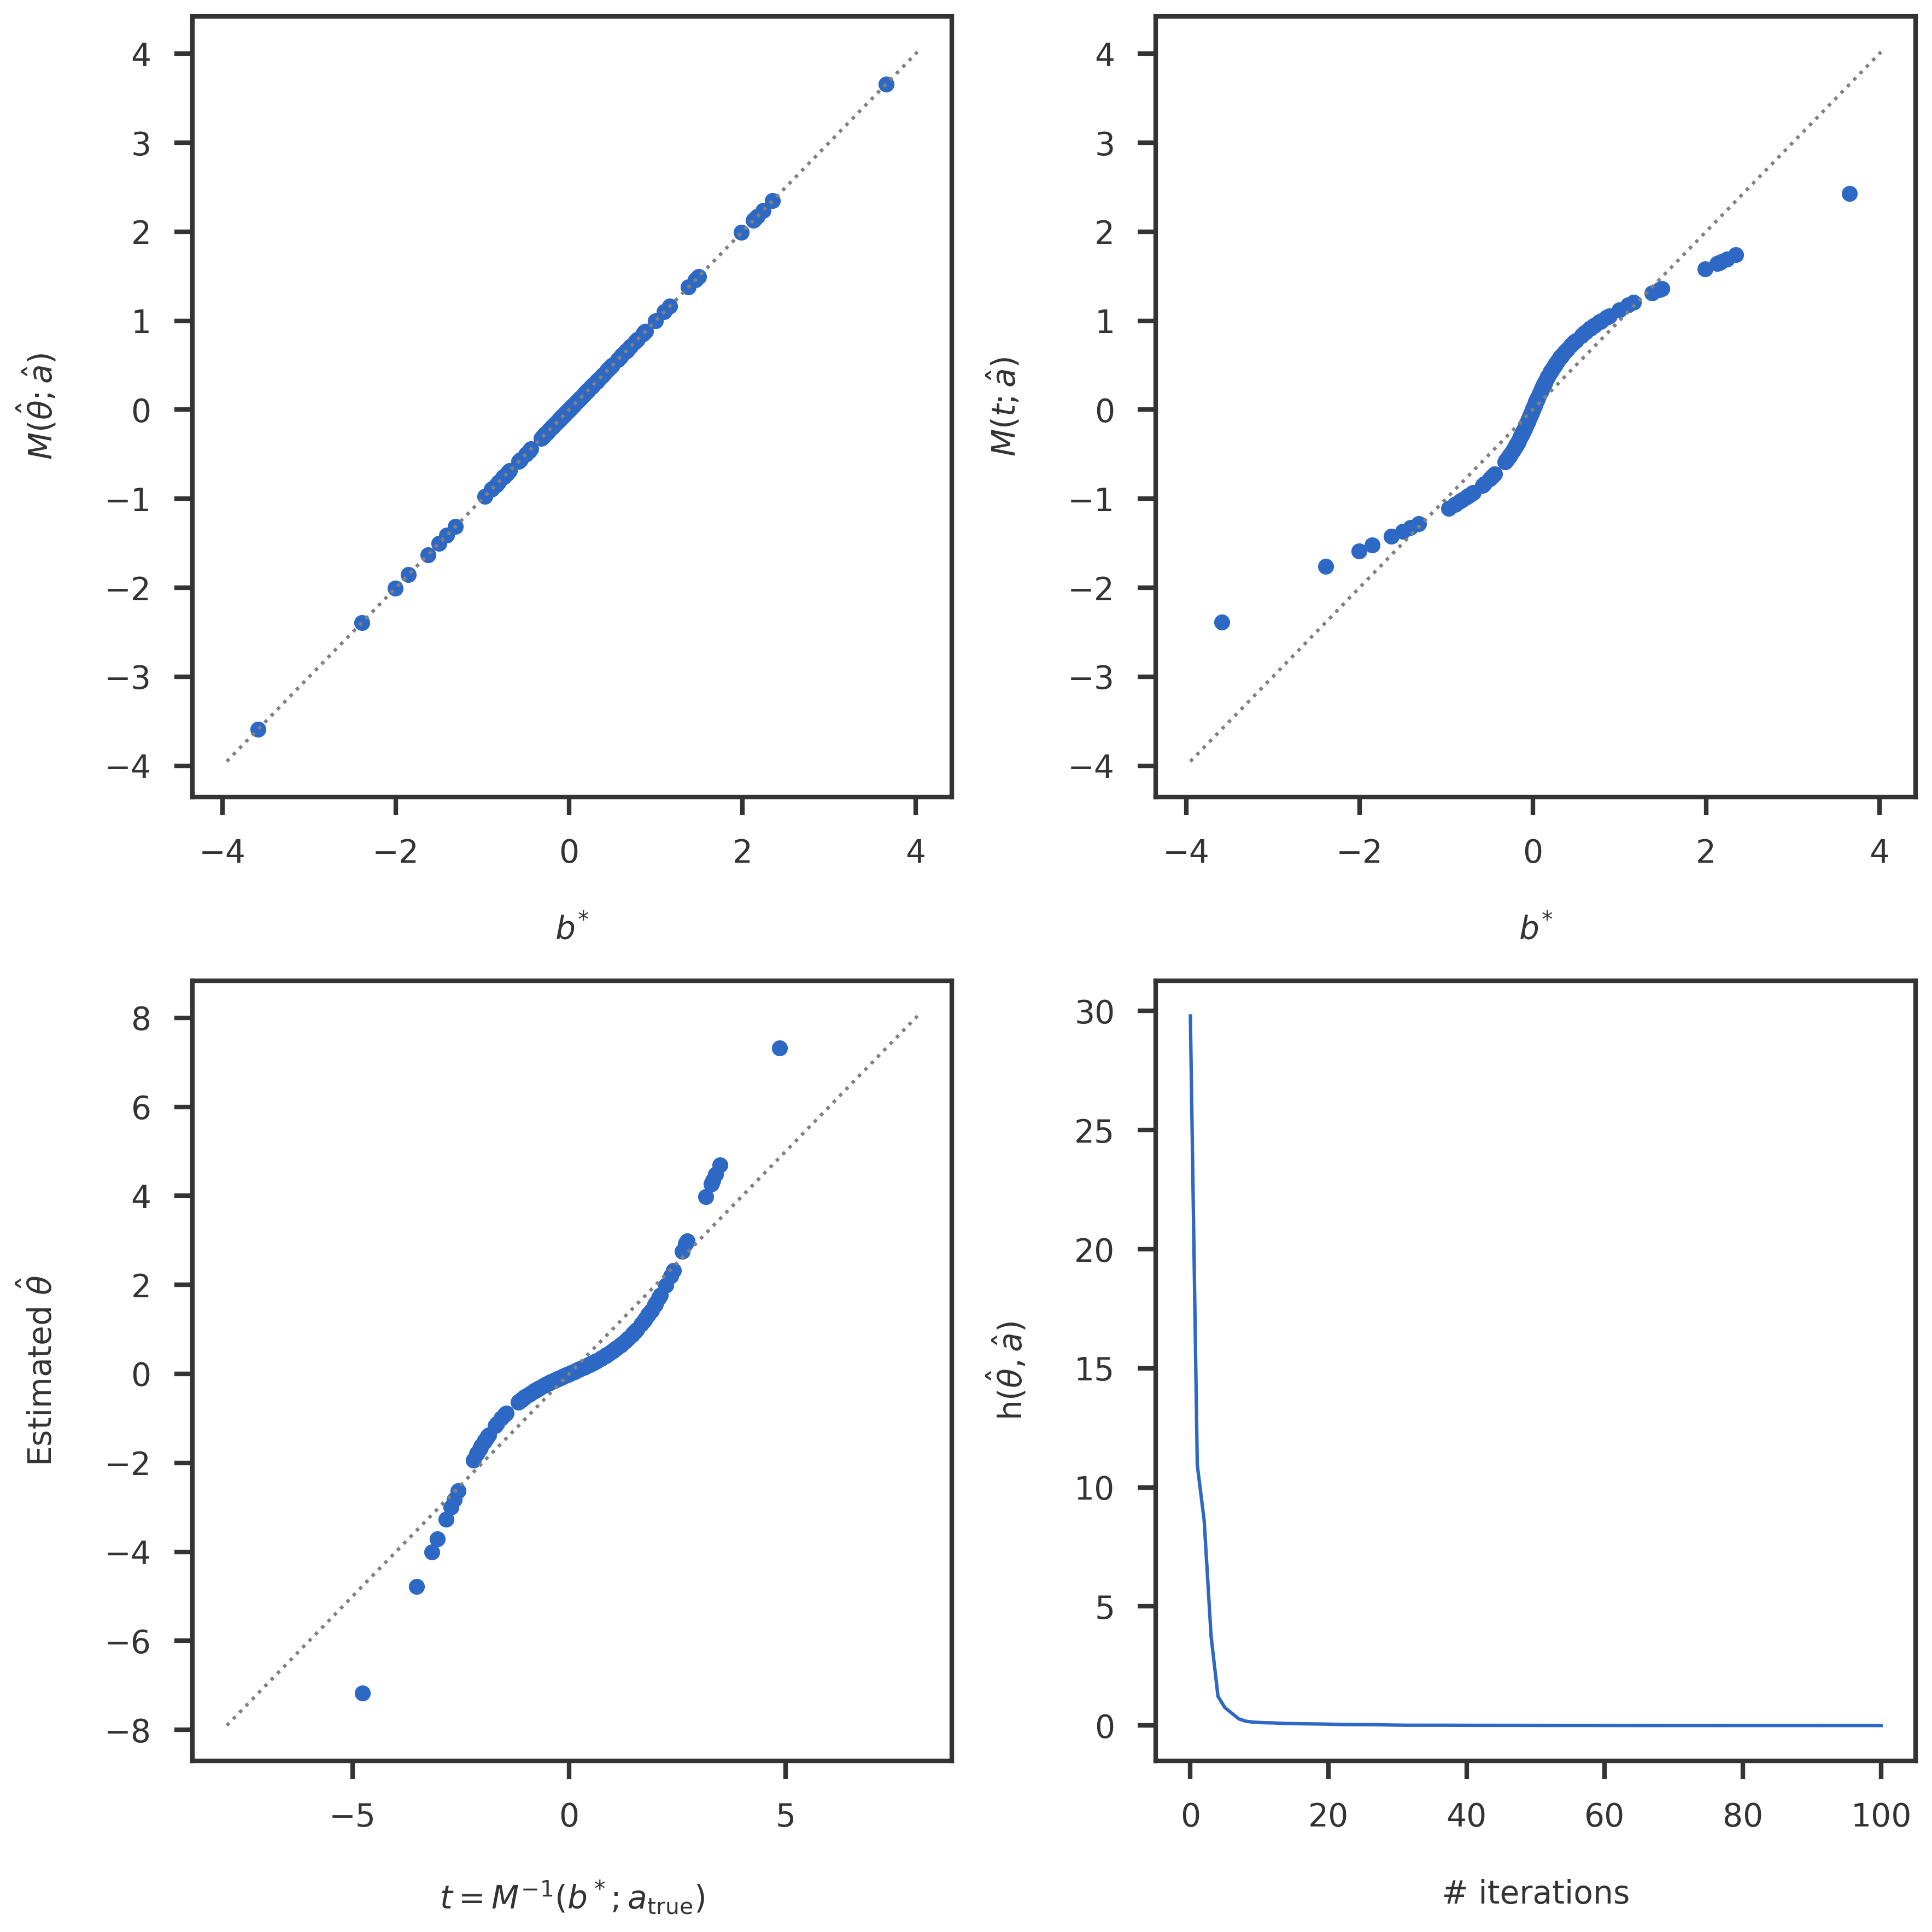

In [21]:
theta_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = lgopt.softmax(a_cg, base = softmax_base)
lj_cg = cg_min.x[p:2*p]
#print ("True w:", wtrue)
print("Est. w: ", ', '.join([f"{x:.3f}" for x in w_cg]))
print("Est. Lagrangian (for non-zero b): ")
print(lj_cg[btrue!=0])

b_cg = lgopt.shrink_theta(theta_cg, strue, w_cg, sk, dj)
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(bconst, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel(r"$b^{*}$")
ax1.set_ylabel(r"$M(\hat{\theta}; \hat{a})$")

b_cg_gpost = lgopt.shrink_theta(theta_newraph, strue, w_cg, sk, dj)
ax2.scatter(bconst, b_cg_gpost)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"$b^{*}$")
ax2.set_ylabel(r"$M(t; \hat{a})$")

ax3.scatter(theta_newraph, theta_cg)
mpl_utils.plot_diag(ax3)
ax3.set_xlabel(r'''$t = M^{-1}(b^*; a_{\mathrm{true}})$''')
ax3.set_ylabel(r'''Estimated $\hat{\theta}$''')

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = lgopt.softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = lgopt.objective_numeric_lagrangian(params, strue, sk, dj, bpostmean, 
                                                               p, k, softmax_base)
ax4.plot(np.arange(niter + 1), allobjs)
ax4.set_xlabel("# iterations")
ax4.set_ylabel(r"h($\hat{\theta}, \hat{a}$)")

plt.tight_layout()
plt.show()

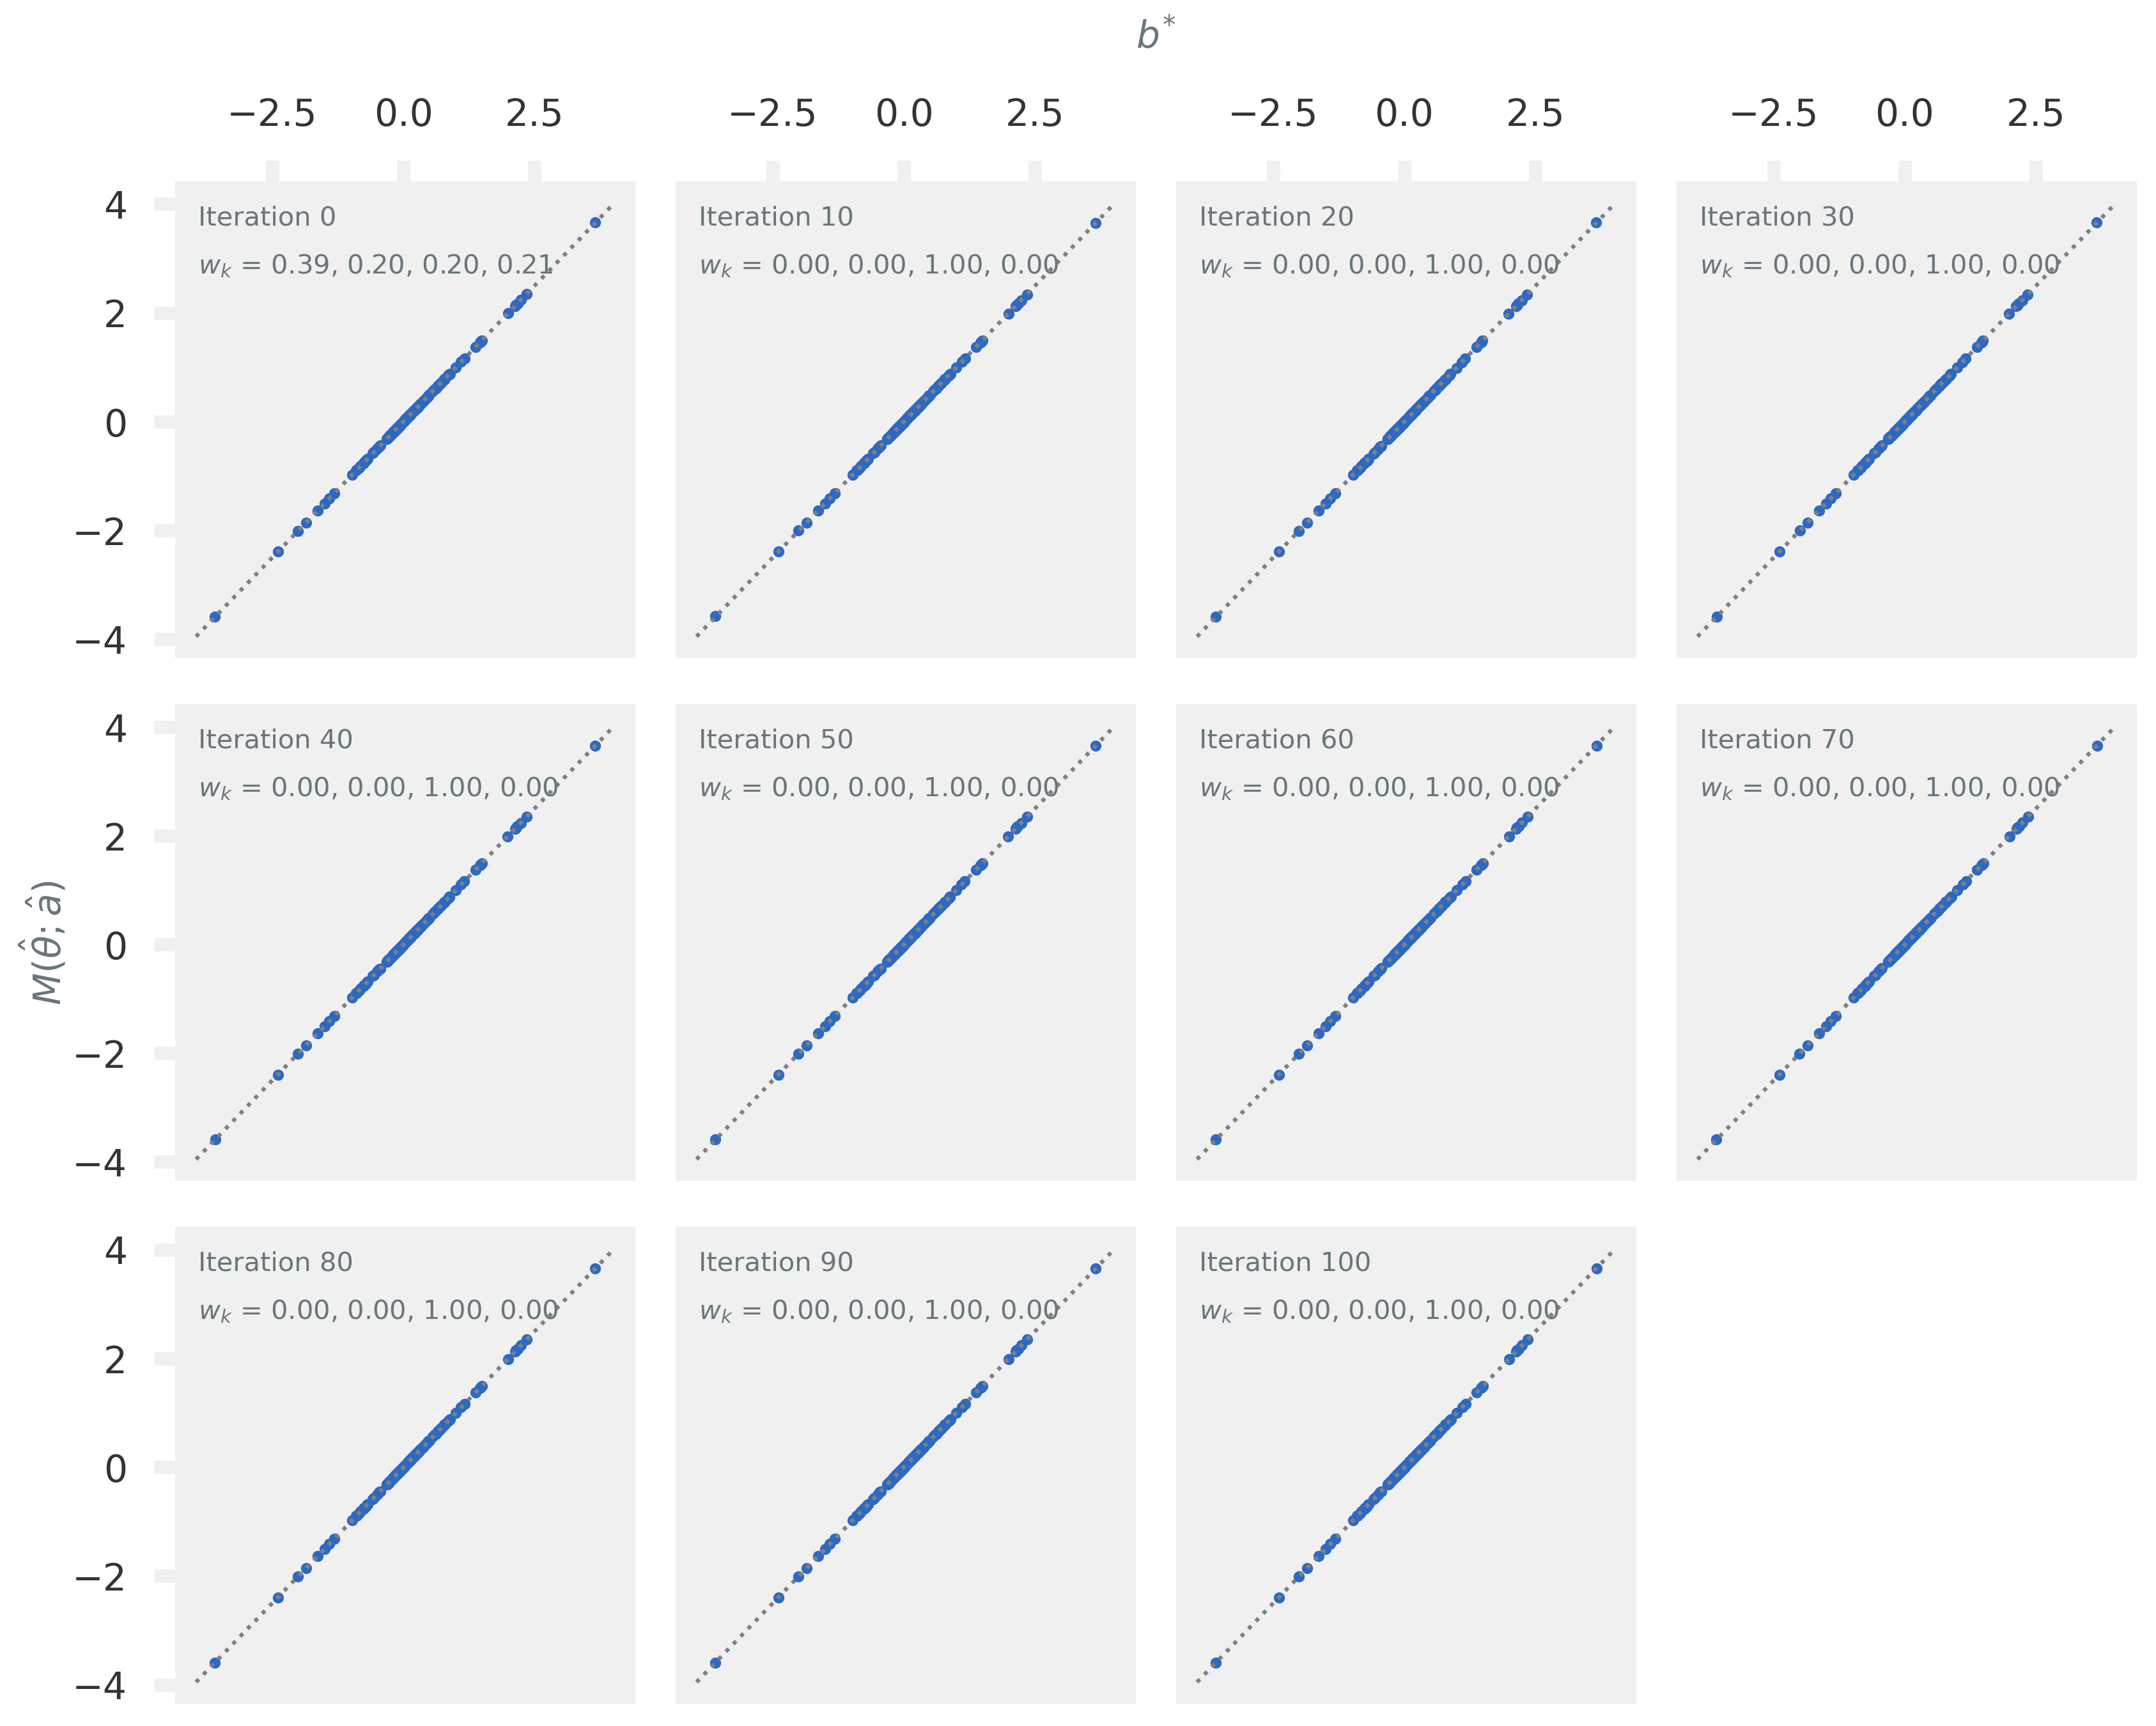

In [23]:
subplot_h = 1.8
nstep = 10
nplot = int(niter / nstep) + 1
ncol  = 4
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
figscale = 12.0 / figw

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

fig = plt.figure(figsize = (figw * figscale, figh * figscale))
axmain = fig.add_subplot(111)

for i in range(nplot):
    ax  = fig.add_subplot(nrow, ncol, i + 1)
    itr = i * nstep
    
    params = cg_min.allvecs[itr]
    z_it = params[:p]
    a_it = params[2*p:]
    #lj_it = params[p:2*p]
    w_it = lgopt.softmax(a_it, base = softmax_base)
    b_it = lgopt.shrink_theta(z_it, strue, w_it, sk, dj)
    
    ax.scatter(bconst, b_it, s=10)
    mpl_utils.plot_diag(ax)
    
    wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
    itrtext = f"Iteration {itr}"
    
    ax.text(0.05, 0.85, wtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    #ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.set_ylabel(r"$M(\hat{\theta}; \hat{a})$", labelpad = 40, color = text_color)
axmain.set_xlabel(r'$b^{*}$', labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
# plt.savefig(f'../plots/{fileprefix}.pdf', bbox_inches='tight')
# plt.savefig(f'../plots/{fileprefix}.png', bbox_inches='tight')
plt.show()